In [9]:
PRFX_ESMB = 'MelInfEsmb0808C1'

In [18]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
import matplotlib.pyplot as plt
from tqdm import tqdm

class Param: pass

p_esmb = f'../output/{PRFX_ESMB}'; Path(p_esmb).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

In [11]:
prfx2wgt = {
    'MelInf0726B2tta16': 0.25,
    'MelInf0805A1tta16': 0.25,
    'MelInf0728A1tta16': 1.0,
    'MelInf0728B1tta16': 0.25,
    'MelInf0805C1tta16': 0.25,
    'MelInf0727A1tta16': 0.25,
    'MelInf0805D1tta16': 0.25,
    'MelInf0727B1tta16': 0.5,
    'MelInf0805E1tta16': 0.5,
    'MelInf0726G2tta16': 0.25,
    'MelInf0726G4tta16': 0.25,
    'MelInf0726H2tta16': 1,
    'MelInf0729H1tta16': 1,
    'MelInf0729E1tta16': 1,
    'MelInf0729D1tta16': 1,
#     'MelInf0806C1tta16': 1,
    'MelInf0729F1tta16': 0.5,
    'MelInf0806D1tta16': 0.5,
    'MelInf0729C1tta16': 0.5,
    'MelInf0729C1tta16epc456': 0.5,
    'Mel0806E1tta16epc345': 0.5,
    'MelInf0729G3tta16epc567': 1,
    'MelInf0801A1tta16': 1,
}

In [12]:
prfx2oofs = {}
for prfx in prfx2wgt.keys():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)

    oofs = np.array(oofs)
    prfx2oofs[prfx] = oofs
    
    scr = roc_auc(ys, oofs)
    print(param.ARCH, param.SZ, f'{scr:.4f}', end=' ')
    
    idx20 = np.where(dftrn.source==20)[0]
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs[idx20])
    print(f'{scr20:.4f}', prfx2wgt[prfx], prfx)

efficientnet-b0 224 0.9279 0.8960 0.25 MelInf0726B2tta16
efficientnet-b0 224 0.9236 0.8962 0.25 MelInf0805A1tta16
efficientnet-b1 224 0.9301 0.9082 1.0 MelInf0728A1tta16
efficientnet-b2 224 0.9298 0.9062 0.25 MelInf0728B1tta16
efficientnet-b2 224 0.9287 0.9053 0.25 MelInf0805C1tta16
efficientnet-b3 224 0.9294 0.9063 0.25 MelInf0727A1tta16
efficientnet-b3 224 0.9292 0.9064 0.25 MelInf0805D1tta16
efficientnet-b4 224 0.9318 0.9094 0.5 MelInf0727B1tta16
efficientnet-b4 224 0.9312 0.9103 0.5 MelInf0805E1tta16
efficientnet-b5 224 0.9288 0.9113 0.25 MelInf0726G2tta16
efficientnet-b5 224 0.9277 0.8979 0.25 MelInf0726G4tta16
efficientnet-b6 224 0.9317 0.9139 1 MelInf0726H2tta16
efficientnet-b0 384 0.9336 0.9063 1 MelInf0729H1tta16
efficientnet-b1 384 0.9340 0.9196 1 MelInf0729E1tta16
efficientnet-b2 384 0.9347 0.9205 1 MelInf0729D1tta16
efficientnet-b3 384 0.9330 0.9169 0.5 MelInf0729F1tta16
efficientnet-b3 384 0.9353 0.9219 0.5 MelInf0806D1tta16
efficientnet-b4 384 0.9344 0.9224 0.5 MelInf0729

In [13]:
oofs_esmb= np.zeros(len(dftrn))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    oofs_esmb += wgt*prfx2oofs[prfx]
    scr = roc_auc(ys, oofs_esmb)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs_esmb[idx20])
print(PRFX_ESMB, f'{scr:.4f}', f'{scr20:.4f}')

MelInfEsmb0808C1 0.9415 0.9257


100%|██████████| 200/200 [00:08<00:00, 22.89it/s]


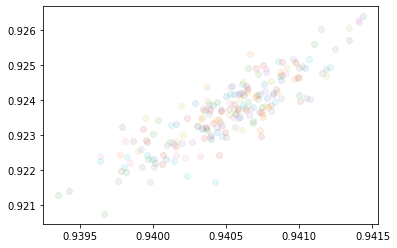

In [19]:
bstscr = 0
bstscr20 = 0
for i in tqdm(range(200)):
    rndwgts = np.random.rand(len(prfx2oofs))
    oofs = np.vstack(list(prfx2oofs.values())).T
    oofswgted = np.average(oofs, axis=1, weights=rndwgts,)
    scr = roc_auc(ys, oofswgted)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofswgted[idx20])
    if scr>bstscr: 
        bstscr=scr
        rndwgts_bstscr=rndwgts
    if scr20>bstscr20: 
        bstscr20=scr20
        rndwgts_bstscr20=rndwgts
    plt.scatter(scr, scr20, alpha=.1)

In [20]:
print(bstscr)
rndwgts = rndwgts_bstscr
print(rndwgts)
oofs = np.vstack(list(prfx2oofs.values())).T
oofs.shape, rndwgts.shape
oofswgted = np.average(oofs, axis=1, weights=rndwgts,)
scr = roc_auc(ys, oofswgted)
scr20 = roc_auc(dftrn.target.iloc[idx20], oofswgted[idx20])
print(f'{scr:.4f},{scr20:.4f}')


0.9414322916148912
[0.08302721 0.11943938 0.30415411 0.01025295 0.23759729 0.41835569
 0.41702716 0.72375205 0.47878806 0.69023412 0.21723009 0.15140517
 0.00920996 0.99432106 0.31876522 0.98532757 0.47326301 0.49539533
 0.46772053 0.85447496 0.93127703 0.9559595 ]
0.9414,0.9264


In [22]:
print(bstscr20)
rndwgts = rndwgts_bstscr20
oofs = np.vstack(list(prfx2oofs.values())).T
oofs.shape, rndwgts.shape
oofswgted = np.average(oofs, axis=1, weights=rndwgts,)
scr = roc_auc(ys, oofswgted)
scr20 = roc_auc(dftrn.target.iloc[idx20], oofswgted[idx20])
print(f'{scr:.4f},{scr20:.4f}')


0.9263867960723877
0.9414,0.9264
